In [ ]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#!pip install pycaret
from pycaret.classification import *
from scipy.stats import spearmanr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, precision_score, f1_score, recall_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report


In [ ]:
# Import dataset
df = pd.read_csv("hf://datasets/scikit-learn/credit-card-clients/UCI_Credit_Card.csv")

In [ ]:
# Util Functions
def replace_col_name(df, col_name_mapping):
    df.rename(columns=col_name_mapping, inplace=True)
    return df

def create_risk_binary(row, limit_mean, last_3_months=["Sept_Pay_status", "August_Pay_status", "July_Pay_status"]):
    high_limit = row["LIMIT_BAL"] > limit_mean

    # Check if payments were made in the last 3 months
    # Assuming no delay in payment status indicates payments were made on time
    # last_3_months = ["Sept_Pay_status", "August_Pay_status", "July_Pay_status"]
    good_payment = all(row[col] <= 0 for col in last_3_months)  # No delays

    if high_limit and good_payment:
        return 1
    else:
        return 0

pay_status_cols =  [
    "April_Pay_status", "May_Pay_status", "June_Pay_status",
    "July_Pay_status", "August_Pay_status", "Sept_Pay_status"
]

# Function to calculate momentum by row
def calculate_weighted_momentum(row, pay_status_cols=pay_status_cols):
    weights = [1, 2, 3, 4, 5, 6]  # Weights for April to September, increasing the closer to October
    weighted_sum = sum(weights[i] * row[pay_status_cols[i]] for i in range(len(pay_status_cols)))
    # return 1 if weighted_sum > 6 else 0  # Adjust threshold as needed
    # return 1 if weighted_sum > 10 else 0  # Adjust threshold as needed
    return 1 if weighted_sum > 20 else 0  # Adjust threshold as needed

# %%
# Rename Columns
column_mappings = {
    "default.payment.next.month": "default_payment_next_month",
    "PAY_0": "Sept_Pay_status",
    "PAY_2": "August_Pay_status",
    "PAY_3": "July_Pay_status",
    "PAY_4": "June_Pay_status",
    "PAY_5": "May_Pay_status",
    "PAY_6": "April_Pay_status",
    "BILL_AMT1": "Sept_Bill_Amount",
    "BILL_AMT2": "August_Bill_Amount",
    "BILL_AMT3": "July_Bill_Amount",
    "BILL_AMT4": "June_Bill_Amount",
    "BILL_AMT5": "May_Bill_Amount",
    "BILL_AMT6": "April_Bill_Amount",
    "PAY_AMT1": "Sept_Pay_Amount",
    "PAY_AMT2": "August_Pay_Amount",
    "PAY_AMT3": "July_Pay_Amount",
    "PAY_AMT4": "June_Pay_Amount",
    "PAY_AMT5": "May_Pay_Amount",
    "PAY_AMT6": "April_Pay_Amount"
}

# apply the rename
df_final = replace_col_name(df, column_mappings)

In [ ]:
# Some cleaning & engineering

# Convert NT dollars to USD (1 USD = 31.8 NTD)
conversion_rate = 1 / 31.8

# List of columns to convert
nt_dollar_columns = [
    "LIMIT_BAL", "Sept_Bill_Amount", "August_Bill_Amount", "July_Bill_Amount",
    "June_Bill_Amount", "May_Bill_Amount", "April_Bill_Amount",
    "Sept_Pay_Amount", "August_Pay_Amount", "July_Pay_Amount",
    "June_Pay_Amount", "May_Pay_Amount", "April_Pay_Amount"
]

# Convert NT dollar columns to US dollars
for col in nt_dollar_columns:
    df_final[col] = df_final[col] * conversion_rate

# Verify the conversion
df_final[nt_dollar_columns].head()

# Calculate momentum based on payment status
# Define the payment status columns in chronological order
pay_status_cols = [
    "April_Pay_status", "May_Pay_status", "June_Pay_status",
    "July_Pay_status", "August_Pay_status", "Sept_Pay_status"
]

df_final["Momentum"] = df_final.apply(calculate_weighted_momentum, axis=1)
df_final["Momentum_Label"] = df_final["Momentum"].map({0: "Stable/Improving", 1: "Bad Momentum"})

In [ ]:
# More columns engineering
# We don't need ID
df_final.drop("ID", inplace = True, axis = 1)

# columns after the change:
print(f"Columns of the dataset after the change:\n{df_final.info()}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   SEX                         30000 non-null  int64  
 2   EDUCATION                   30000 non-null  int64  
 3   MARRIAGE                    30000 non-null  int64  
 4   AGE                         30000 non-null  int64  
 5   Sept_Pay_status             30000 non-null  int64  
 6   August_Pay_status           30000 non-null  int64  
 7   July_Pay_status             30000 non-null  int64  
 8   June_Pay_status             30000 non-null  int64  
 9   May_Pay_status              30000 non-null  int64  
 10  April_Pay_status            30000 non-null  int64  
 11  Sept_Bill_Amount            30000 non-null  float64
 12  August_Bill_Amount          30000 non-null  float64
 13  July_Bill_Amount            300

In [ ]:
# We also don't need sex, as we don't want to discriminate based on sex
df_final.drop("SEX", inplace = True, axis = 1)

# columns after the change:
print(f"Columns of the dataset after the change:\n{df_final.info()}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LIMIT_BAL                   30000 non-null  float64
 1   EDUCATION                   30000 non-null  int64  
 2   MARRIAGE                    30000 non-null  int64  
 3   AGE                         30000 non-null  int64  
 4   Sept_Pay_status             30000 non-null  int64  
 5   August_Pay_status           30000 non-null  int64  
 6   July_Pay_status             30000 non-null  int64  
 7   June_Pay_status             30000 non-null  int64  
 8   May_Pay_status              30000 non-null  int64  
 9   April_Pay_status            30000 non-null  int64  
 10  Sept_Bill_Amount            30000 non-null  float64
 11  August_Bill_Amount          30000 non-null  float64
 12  July_Bill_Amount            30000 non-null  float64
 13  June_Bill_Amount            300

In [ ]:
# value counts of marriagge_status
df_final["MARRIAGE"].value_counts(normalize= True)

# 2 - Single
# 1 - Married
# 3/0 - othher
# Other takes around 1% of data variance - just a noise, we should drop that

,proportion
MARRIAGE,
2,0.532133
1,0.455300
3,0.010767
0,0.001800


In [ ]:
# drop 3 and 0 class in marriage variable
df_final = df_final[~df_final["MARRIAGE"].isin([0, 3])]

# check
df_final["MARRIAGE"].value_counts(normalize= True)

# It doesn't have an ordinal relationship as it is a nominal categorical variable.
# Let's convert that to binary

,proportion
MARRIAGE,
2,0.538906
1,0.461094


In [ ]:
# Convert marriage to categorical and then to binary
# 1 - Married
# 2 - Single
df_final["MARRIAGE"] = df_final["MARRIAGE"].astype("category")
df_final["MARRIED_FLAG"] = df_final["MARRIAGE"].map({1: 1, 2: 0})

# drop marriage as it is
df_final.drop("MARRIAGE", inplace = True, axis = 1)

KeyError: 'MARRIAGE'

In [ ]:
df_final["MARRIED_FLAG"].value_counts(normalize=True)


,proportion
MARRIED_FLAG,
0,0.538906
1,0.461094


In [ ]:
# Education
# 1 - graduate
# 2 - undergraduate
# 3 - high school
# anything else - other

# Check unique values as well
df_final["EDUCATION"].value_counts(normalize= True)



,proportion
EDUCATION,
2,0.467947
1,0.355501
3,0.161024
5,0.009351
4,0.004051
6,0.001654
0,0.000473


In [ ]:
# THere are some unknown classes which are higher than 4 - potential data error - drop
# Drop anything other than 1, 2, 3
df_final = df_final[df_final["EDUCATION"].isin([1, 2, 3])]

# Create ordinal relationship
# 0 (graduate) - lowest risk
# 1 (undergraduate) - increasing risk
# 2 (high scool) - highest risk
df_final["EDUCATION"] = df_final["EDUCATION"].map({1: 0, 2: 1, 3: 2})

# Check again
df_final["EDUCATION"].value_counts(normalize= True)

,proportion
EDUCATION,
1,0.475328
0,0.361108
2,0.163563


In [ ]:
# bill amounts and payment amounts

# bill columns
bill_columns = [col for col in df_final.columns if 'bill' in col.lower() and 'amount' in col.lower()]

# payment columns
payment_columns = [col for col in df.columns if 'pay' in col.lower() and 'amount' in col.lower() and 'status' not in col.lower()]

# Calculate the average of bills and payments
df_final['average_bill'] = df_final[bill_columns].mean(axis=1)
df_final['average_payment'] = df_final[payment_columns].mean(axis=1)

# new dataset
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29163 entries, 0 to 29999
Data columns (total 27 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   LIMIT_BAL                   29163 non-null  float64 
 1   EDUCATION                   29163 non-null  int64   
 2   AGE                         29163 non-null  int64   
 3   Sept_Pay_status             29163 non-null  int64   
 4   August_Pay_status           29163 non-null  int64   
 5   July_Pay_status             29163 non-null  int64   
 6   June_Pay_status             29163 non-null  int64   
 7   May_Pay_status              29163 non-null  int64   
 8   April_Pay_status            29163 non-null  int64   
 9   Sept_Bill_Amount            29163 non-null  float64 
 10  August_Bill_Amount          29163 non-null  float64 
 11  July_Bill_Amount            29163 non-null  float64 
 12  June_Bill_Amount            29163 non-null  float64 
 13  May_Bill_Amount      

In [ ]:
# Average Repayment Status
# dynamic column search for repayment status
rp_columns = [col for col in df_final.columns if 'pay' in col.lower() and 'status' in col.lower()]

# calculate
df_final["average_repayment_status"] = df_final[rp_columns].mean(axis=1)

# repayment volatility
df_final['repayment_volatility'] = df_final[rp_columns].std(axis = 1)

# Repayment in recent months
recent_months = ["July_Pay_status", "August_Pay_status", "Sept_Pay_status"]
df_final["recent_repayment_mean"] = df_final[recent_months].mean(axis=1)

# Momentum and Volatility
df_final["momentum_volatility_interaction"] = df_final["Momentum"] * df_final["repayment_volatility"]

# Number of Low Repayment Status months
df_final["low_repayment_months"] = (df_final[rp_columns] > 1).sum(axis=1)

# Risk Index
df_final["risk_index_1"] = df_final["momentum_volatility_interaction"] + 0.5 * df_final["low_repayment_months"]

# Repayment deterioration and acceleration
df_final["repayment_deterioration"] = df_final["Sept_Pay_status"] - df_final["June_Pay_status"]
df_final["repayment_acceleration"] = (
    (df_final["Sept_Pay_status"] - df_final["August_Pay_status"]) -
    (df_final["August_Pay_status"] - df_final["July_Pay_status"])
)

# Momentum Recent Mean Interaction
df_final['momentum_recent_mean_interaction'] = df_final['Momentum'] * df_final['recent_repayment_mean']

# Momentum Stability Flag
df_final['momentum_stability_flag'] = np.where(
    (df_final['Momentum'] == 1) & (df_final['repayment_volatility'] < 1.0), 1, 0
)

# Final Formula
df_final["super_default_score_final"] = (
    0.4 * df_final["low_repayment_months"] +              # Core: missed payments
    0.2 * df_final["Momentum"] +                           # Trend: good or bad momentum
    0.1 * df_final["repayment_volatility"] +               # Instability risk
    0.1 * df_final["recent_repayment_mean"] +              # Recent repayment behavior
    0.1 * df_final["momentum_volatility_interaction"] +    # Combined volatility + momentum
    0.05 * df_final["repayment_deterioration"] +           # How much repayment worsened
    0.05 * df_final["repayment_acceleration"]              # Whether worsening accelerated
)

# check new data
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29163 entries, 0 to 29999
Data columns (total 38 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   LIMIT_BAL                         29163 non-null  float64 
 1   EDUCATION                         29163 non-null  int64   
 2   AGE                               29163 non-null  int64   
 3   Sept_Pay_status                   29163 non-null  int64   
 4   August_Pay_status                 29163 non-null  int64   
 5   July_Pay_status                   29163 non-null  int64   
 6   June_Pay_status                   29163 non-null  int64   
 7   May_Pay_status                    29163 non-null  int64   
 8   April_Pay_status                  29163 non-null  int64   
 9   Sept_Bill_Amount                  29163 non-null  float64 
 10  August_Bill_Amount                29163 non-null  float64 
 11  July_Bill_Amount                  29163 non-null  float64 


Correlations with Default Status:
default_payment_next_month          1.000000
super_default_score_final           0.415399
low_repayment_months                0.399298
risk_index_1                        0.394659
Momentum                            0.353713
momentum_recent_mean_interaction    0.335042
Sept_Pay_status                     0.327230
recent_repayment_mean               0.309879
average_repayment_status            0.281847
momentum_volatility_interaction     0.273846
August_Pay_status                   0.263981
repayment_volatility                0.250605
momentum_stability_flag             0.250047
July_Pay_status                     0.234362
June_Pay_status                     0.214627
May_Pay_status                      0.203990
April_Pay_status                    0.187013
LIMIT_BAL                          -0.153576
average_payment                    -0.108993
repayment_deterioration             0.105689
Sept_Pay_Amount                    -0.076875
August_Pay_Amount    

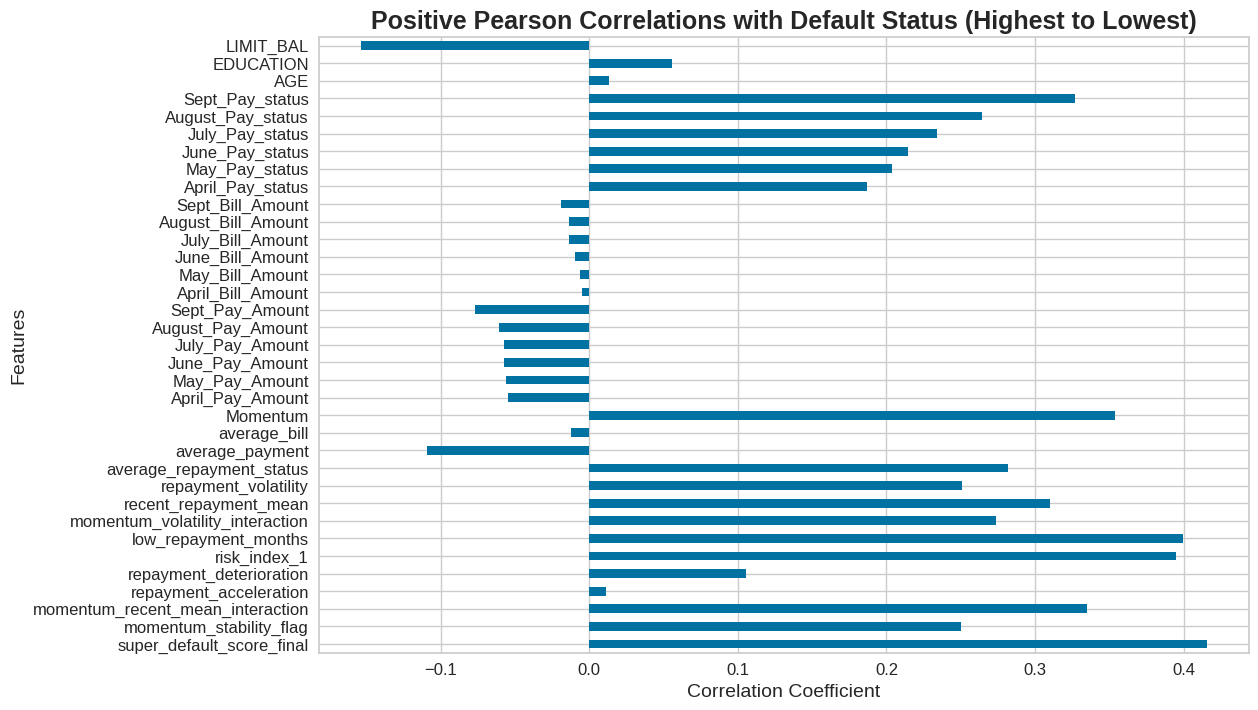

In [ ]:
# Check correlations
# Select only numeric columns
numeric_cols = df_final.select_dtypes(include='number')

# Pearson correlation
pearson_corr = numeric_cols.corr()['default_payment_next_month']

# Sort and plot
correlations_with_target = pearson_corr.reindex(pearson_corr.abs().sort_values(ascending=False).index)
# Check correlations again
numeric_cols = df_final.select_dtypes(include='number')

# Pearson correlation
pearson_corr = numeric_cols.corr()['default_payment_next_month'].drop('default_payment_next_month')

# Print
print(f"Correlations with Default Status:\n{correlations_with_target}\n")

# Plot
plt.figure(figsize=(12, 8))
pearson_corr.plot(kind='barh')

# Invert y-axis
plt.gca().invert_yaxis()

# Design
# Titlee
plt.title('Positive Pearson Correlations with Default Status (Highest to Lowest)', fontsize=18, fontweight='bold')

# X-axis
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.xticks(fontsize=12)

# Y-axis
plt.ylabel('Features', fontsize=14)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
# Also, I don't think we momentum_label as we already have momentum
df_final.drop(columns = ["Momentum_Label"], inplace = True)

# Check
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29163 entries, 0 to 29999
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   LIMIT_BAL                         29163 non-null  float64 
 1   EDUCATION                         29163 non-null  int64   
 2   AGE                               29163 non-null  int64   
 3   Sept_Pay_status                   29163 non-null  int64   
 4   August_Pay_status                 29163 non-null  int64   
 5   July_Pay_status                   29163 non-null  int64   
 6   June_Pay_status                   29163 non-null  int64   
 7   May_Pay_status                    29163 non-null  int64   
 8   April_Pay_status                  29163 non-null  int64   
 9   Sept_Bill_Amount                  29163 non-null  float64 
 10  August_Bill_Amount                29163 non-null  float64 
 11  July_Bill_Amount                  29163 non-null  float64 


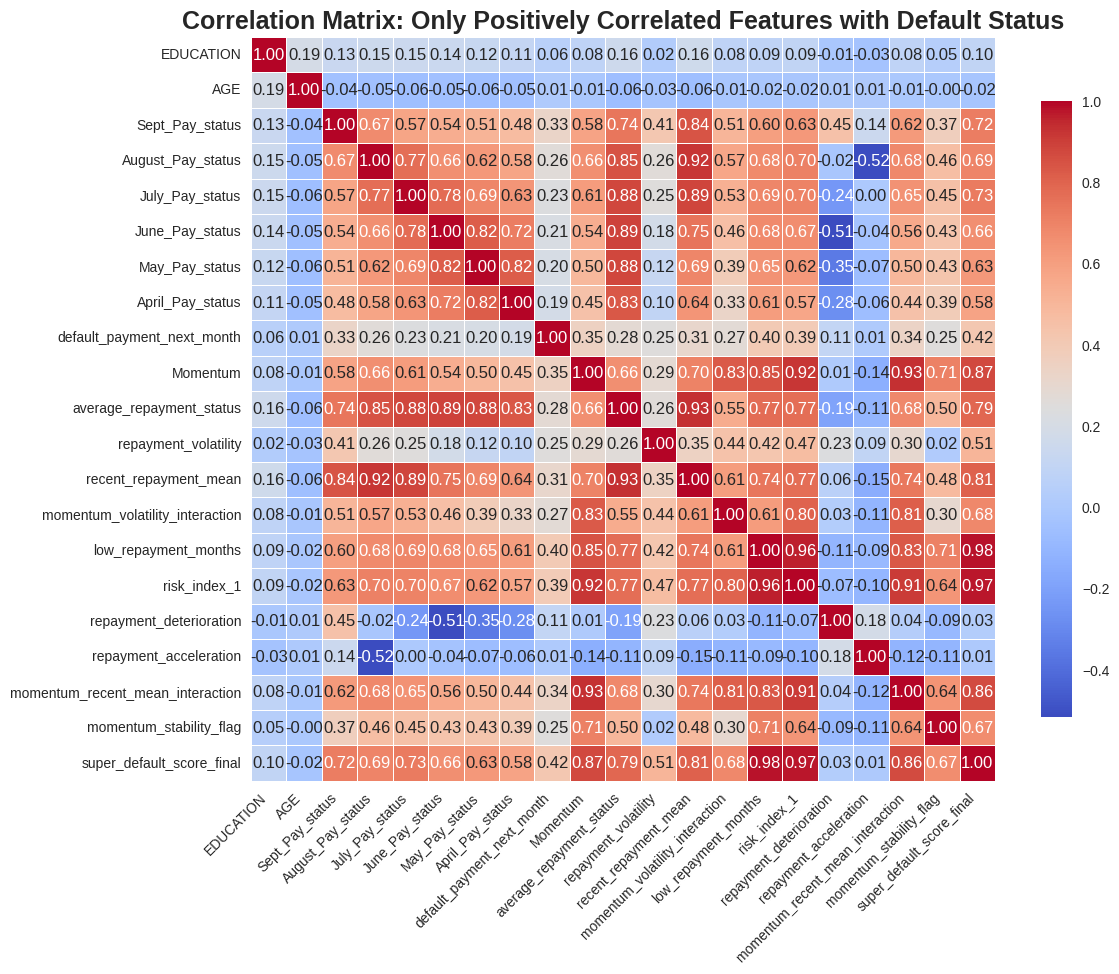

In [ ]:
# %%
# Correlation Matrix
full_corr_matrix = numeric_cols.corr()

# Get features with positive correlation to default_status
positive_corr_features = full_corr_matrix['default_payment_next_month'][full_corr_matrix['default_payment_next_month'] > 0].index.tolist()

# Subset the correlation matrix dynamically
positive_corr_matrix = full_corr_matrix.loc[positive_corr_features, positive_corr_features]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    positive_corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

# Design
# Title
plt.title('Correlation Matrix: Only Positively Correlated Features with Default Status', fontsize=18, fontweight='bold')

# X-axis
plt.xticks(rotation=45, ha='right')

# Y-axis
plt.yticks(rotation=0)

plt.show()


In [ ]:
# Statistical tests
# For Numeric Variables
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, pearsonr, shapiro

# Recreate Numeric Columns after the drop
numeric_cols = df_final.select_dtypes(include='number')
numeric_cols = numeric_cols.drop(columns=['default_status'], errors='ignore')


# 1. t-tests / Mann-Whitney U Test for Numerical Features
print("\n### T-Tests / Mann-Whitney U Tests for Numerical Features ###\n")

for col in numeric_cols.columns:
    group0 = df_final[df_final['default_payment_next_month'] == 0][col]
    group1 = df_final[df_final['default_payment_next_month'] == 1][col]

    # First check if both groups are normally distributed
    stat0, p0 = shapiro(group0)
    stat1, p1 = shapiro(group1)

    if p0 > 0.05 and p1 > 0.05:
        # If both are normal, use t-test
        stat, p = ttest_ind(group0, group1)
        test_name = "T-test"
    else:
        # Otherwise, use Mann-Whitney U Test
        stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
        test_name = "Mann-Whitney U"

    print(f"{col}: {test_name} --> statistic = {stat:.4f}, p-value = {p:.4f}")
    # Interpretation: p < 0.05 means significant difference between default groups
    # But tests are just for screening, do not drop predictors based on that.


### T-Tests / Mann-Whitney U Tests for Numerical Features ###

LIMIT_BAL: Mann-Whitney U --> statistic = 91053151.5000, p-value = 0.0000
EDUCATION: Mann-Whitney U --> statistic = 68442639.5000, p-value = 0.0000
AGE: Mann-Whitney U --> statistic = 73353701.0000, p-value = 0.4889
Sept_Pay_status: Mann-Whitney U --> statistic = 45654349.0000, p-value = 0.0000
August_Pay_status: Mann-Whitney U --> statistic = 53358430.0000, p-value = 0.0000
July_Pay_status: Mann-Whitney U --> statistic = 55532129.5000, p-value = 0.0000
June_Pay_status: Mann-Whitney U --> statistic = 57808262.0000, p-value = 0.0000
May_Pay_status: Mann-Whitney U --> statistic = 59134912.5000, p-value = 0.0000
April_Pay_status: Mann-Whitney U --> statistic = 60479107.5000, p-value = 0.0000
Sept_Bill_Amount: Mann-Whitney U --> statistic = 76385569.5000, p-value = 0.0000
August_Bill_Amount: Mann-Whitney U --> statistic = 75408525.5000, p-value = 0.0061
July_Bill_Amount: Mann-Whitney U --> statistic = 75140608.0000, p-value = 

In [ ]:
# check columns
df_final.columns

Index(['LIMIT_BAL', 'EDUCATION', 'AGE', 'Sept_Pay_status', 'August_Pay_status',
       'July_Pay_status', 'June_Pay_status', 'May_Pay_status',
       'April_Pay_status', 'Sept_Bill_Amount', 'August_Bill_Amount',
       'July_Bill_Amount', 'June_Bill_Amount', 'May_Bill_Amount',
       'April_Bill_Amount', 'Sept_Pay_Amount', 'August_Pay_Amount',
       'July_Pay_Amount', 'June_Pay_Amount', 'May_Pay_Amount',
       'April_Pay_Amount', 'default_payment_next_month', 'Momentum',
       'MARRIED_FLAG', 'average_bill', 'average_payment',
       'average_repayment_status', 'repayment_volatility',
       'recent_repayment_mean', 'momentum_volatility_interaction',
       'low_repayment_months', 'risk_index_1', 'repayment_deterioration',
       'repayment_acceleration', 'momentum_recent_mean_interaction',
       'momentum_stability_flag', 'super_default_score_final'],
      dtype='object')

In [ ]:
# Let's test polynomials need
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Selected continuous variables for transformation
continuous_candidates = [
    'LIMIT_BAL',
    'AGE',
    'Sept_Bill_Amount',
      'August_Bill_Amount', 'July_Bill_Amount', 'June_Bill_Amount',
      'May_Bill_Amount', 'April_Bill_Amount', 'Sept_Pay_Amount',
      'August_Pay_Amount', 'July_Pay_Amount', 'June_Pay_Amount',
      'May_Pay_Amount', 'April_Pay_Amount',
    'repayment_volatility',
    'momentum_volatility_interaction',
    'risk_index_1',
    'super_default_score_final',
    'recent_repayment_mean',
    'average_bill',
    'average_payment',
    'repayment_deterioration',
    'repayment_acceleration',
    'momentum_recent_mean_interaction',
    'momentum_stability_flag',
    'low_repayment_months',
    'super_default_score_final',
    'EDUCATION'
]

results = []

# Drop NaNs from ratio column
df_test = df_final.copy()

# Target variable
y = df_test['default_payment_next_month']

# Loop through each continuous variable and test polynomial and log transforms
for col in continuous_candidates:
    df_temp = df_test.copy()

    # Create transformed versions
    df_temp[f'{col}_squared'] = df_temp[col] ** 2
    df_temp[f'{col}_log'] = np.log1p(df_temp[col].clip(lower=0))

    # Prepare datasets
    base_X = df_temp[[col]]
    squared_X = df_temp[[col, f'{col}_squared']]
    log_X = df_temp[[col, f'{col}_log']]

    model = LogisticRegression(max_iter=1000)

    # Cross-validated F1 scores
    f1_base = cross_val_score(model, base_X, y, scoring='f1', cv=5).mean()
    f1_sq = cross_val_score(model, squared_X, y, scoring='f1', cv=5).mean()
    f1_log = cross_val_score(model, log_X, y, scoring='f1', cv=5).mean()

    results.append({
        'feature': col,
        'f1_base': f1_base,
        'f1_with_squared': f1_sq,
        'f1_with_log': f1_log,
        'best_transformation': max(
            [(f1_base, 'base'), (f1_sq, 'squared'), (f1_log, 'log')],
            key=lambda x: x[0]
        )[1]
    })

results_df = pd.DataFrame(results).sort_values(by='f1_with_squared', ascending=False)

In [ ]:
# Check
results_df

,feature,f1_base,f1_with_squared,f1_with_log,best_transformation
17,super_default_score_final,0.403626,0.432675,0.442556,log
26,super_default_score_final,0.403626,0.432675,0.442556,log
16,risk_index_1,0.401603,0.422979,0.444977,log
25,low_repayment_months,0.335818,0.418448,0.418448,squared
23,momentum_recent_mean_interaction,0.377042,0.402769,0.410724,log
18,recent_repayment_mean,0.321942,0.352913,0.410104,log
15,momentum_volatility_interaction,0.276592,0.302523,0.306087,log
24,momentum_stability_flag,0.266043,0.266043,0.266043,base
14,repayment_volatility,0.083008,0.075199,0.072829,base
21,repayment_deterioration,0.000000,0.068035,0.011533,squared


In [ ]:
# check
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29163 entries, 0 to 29999
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   LIMIT_BAL                         29163 non-null  float64 
 1   EDUCATION                         29163 non-null  int64   
 2   AGE                               29163 non-null  int64   
 3   Sept_Pay_status                   29163 non-null  int64   
 4   August_Pay_status                 29163 non-null  int64   
 5   July_Pay_status                   29163 non-null  int64   
 6   June_Pay_status                   29163 non-null  int64   
 7   May_Pay_status                    29163 non-null  int64   
 8   April_Pay_status                  29163 non-null  int64   
 9   Sept_Bill_Amount                  29163 non-null  float64 
 10  August_Bill_Amount                29163 non-null  float64 
 11  July_Bill_Amount                  29163 non-null  float64 


In [ ]:
# Catgorical Variables
# Make all required categorical transformations
# Convert selected columns to categorical
categorical_columns = [
    'MARRIED_FLAG',
    'Momentum',
    'momentum_stability_flag'
]

df_converted = df_final.copy()

# Convert to category dtype
for col in categorical_columns:
    df_converted[col] = df_converted[col].astype('category')

# Chi-square Tests for Categorical Features
print("\n### Chi-Square Tests for Categorical Features ###\n")

for col in categorical_columns:
    contingency_table = pd.crosstab(df_converted[col], df_converted['default_payment_next_month'])
    stat, p, dof, expected = chi2_contingency(contingency_table)
    print(f"{col}: Chi-square statistic = {stat:.4f}, p-value = {p:.4f}")
    # Interpretation: p < 0.05 means feature and default status are dependent


### Chi-Square Tests for Categorical Features ###

MARRIED_FLAG: Chi-square statistic = 28.6701, p-value = 0.0000
Momentum: Chi-square statistic = 3645.9415, p-value = 0.0000
momentum_stability_flag: Chi-square statistic = 1820.8157, p-value = 0.0000


In [ ]:
# Select features where log transformation had best F1 and improved over base
final_features = [
    "super_default_score_final",
    "risk_index_1",
    "low_repayment_months",
    "momentum_recent_mean_interaction",
    "recent_repayment_mean",
    "average_repayment_status",
    "momentum_volatility_interaction"
]


# Create log-transformed versions of those features
df_logs = df_converted.copy()

for col in final_features:
    df_logs[f'{col}_log'] = np.log1p(df_logs[col].clip(lower=0))
    df_logs.drop(columns=f'{col}', inplace=True)

# info
df_logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29163 entries, 0 to 29999
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   LIMIT_BAL                             29163 non-null  float64 
 1   EDUCATION                             29163 non-null  int64   
 2   AGE                                   29163 non-null  int64   
 3   Sept_Pay_status                       29163 non-null  int64   
 4   August_Pay_status                     29163 non-null  int64   
 5   July_Pay_status                       29163 non-null  int64   
 6   June_Pay_status                       29163 non-null  int64   
 7   May_Pay_status                        29163 non-null  int64   
 8   April_Pay_status                      29163 non-null  int64   
 9   Sept_Bill_Amount                      29163 non-null  float64 
 10  August_Bill_Amount                    29163 non-null  float64 
 11  July_Bi

In [ ]:
# Check correlations
# Select only numeric columns
numeric_cols = df_logs.select_dtypes(include='number')

# Pearson correlation
pearson_corr = numeric_cols.corr()['default_payment_next_month']

# Sort and plot
correlations_with_target = pearson_corr.reindex(pearson_corr.abs().sort_values(ascending=False).index)
# Check correlations again
numeric_cols = df_logs.select_dtypes(include='number')

# Pearson correlation
pearson_corr = numeric_cols.corr()['default_payment_next_month'].drop('default_payment_next_month')

# Print
print(f"Correlations with Default Status:\n{correlations_with_target}\n")

Correlations with Default Status:
default_payment_next_month              1.000000
super_default_score_final_log           0.424340
low_repayment_months_log                0.407699
risk_index_1_log                        0.407488
recent_repayment_mean_log               0.400475
average_repayment_status_log            0.388033
momentum_recent_mean_interaction_log    0.350130
Sept_Pay_status                         0.327230
momentum_volatility_interaction_log     0.285236
August_Pay_status                       0.263981
repayment_volatility                    0.250605
July_Pay_status                         0.234362
June_Pay_status                         0.214627
May_Pay_status                          0.203990
April_Pay_status                        0.187013
LIMIT_BAL                              -0.153576
average_payment                        -0.108993
repayment_deterioration                 0.105689
Sept_Pay_Amount                        -0.076875
August_Pay_Amount                  

In [ ]:
# filter and include variables with corelation higher than 0.15 in ne dataframe
# Calculate correlation with the target
correlation_matrix = df_logs.corr()
target_corr = correlation_matrix["default_payment_next_month"]

# Filter features with absolute correlation > 0.15 (excluding the target itself)
selected_features = target_corr[abs(target_corr) > 0.15].index.tolist()
selected_features = [col for col in selected_features if col != "default_payment_next_month"]

# Create new DataFrame with selected features + target
df_filtered = df_logs[selected_features + ["default_payment_next_month"]]

# View selected feature correlations
print("Selected Features with correlation > 0.15:")
print(target_corr[abs(target_corr) > 0.15])


Selected Features with correlation > 0.15:
LIMIT_BAL                              -0.153576
Sept_Pay_status                         0.327230
August_Pay_status                       0.263981
July_Pay_status                         0.234362
June_Pay_status                         0.214627
May_Pay_status                          0.203990
April_Pay_status                        0.187013
default_payment_next_month              1.000000
Momentum                                0.353713
repayment_volatility                    0.250605
momentum_stability_flag                 0.250047
super_default_score_final_log           0.424340
risk_index_1_log                        0.407488
low_repayment_months_log                0.407699
momentum_recent_mean_interaction_log    0.350130
recent_repayment_mean_log               0.400475
average_repayment_status_log            0.388033
momentum_volatility_interaction_log     0.285236
Name: default_payment_next_month, dtype: float64


In [ ]:
### Feature Selection ###
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import time

# Variables
# Target variable
Y = df_filtered["default_payment_next_month"]

# Feature candidates
X = df_filtered.drop(columns=["default_payment_next_month"])

# Define model
model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"
)


# Build pipeline: scaling + model
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', model)
])

# Setup Sequential Feature Selector
sfs = SFS(estimator=pipeline,
          k_features="best",
          forward=True,
          floating=True,
          scoring=make_scorer(f1_score),
          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
          n_jobs=-1,
          verbose=2)

# Run SFS
start_time = time.time()
sfs.fit(X, y)
end_time = time.time()

# Extract Selected Features
selected_features = list(sfs.k_feature_names_)
print(f"\n Selected Features ({len(selected_features)}):\n", selected_features)
print(f" Feature selection completed in {end_time - start_time:.2f} seconds")


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:   46.0s finished

[2025-04-17 23:48:55] Features: 1/17 -- score: 0.5350435145778235[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   58.5s finished

[2025-04-17 23:49:54] Features: 2/17 -- score: 0.5358353447620161[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   54.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    7.6s finished

[2025-04-17 23:50:56] Features: 3/17 -- score: 0.5368272980311459[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   54.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent 


 Selected Features (12):
 ['Sept_Pay_status', 'August_Pay_status', 'July_Pay_status', 'June_Pay_status', 'May_Pay_status', 'Momentum', 'momentum_stability_flag', 'risk_index_1_log', 'low_repayment_months_log', 'momentum_recent_mean_interaction_log', 'recent_repayment_mean_log', 'momentum_volatility_interaction_log']
 Feature selection completed in 3316.32 seconds


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.2min finished

[2025-04-18 00:43:25] Features: 17/17 -- score: 0.5299021626722764

In [ ]:
# variables
variables = ['Sept_Pay_status', 'August_Pay_status', 'July_Pay_status', 'June_Pay_status', 'May_Pay_status',
 'Momentum',
 'momentum_stability_flag',
 'risk_index_1_log',
 'low_repayment_months_log',
 'momentum_recent_mean_interaction_log',
 'recent_repayment_mean_log',
 'momentum_volatility_interaction_log']

# Variables
# Target variable
Y = df_filtered["default_payment_next_month"]

# Feature candidates
X = df_filtered.drop(columns=["default_payment_next_month"])

# Variables set
X = X[variables]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=42)

# Model
model = LGBMClassifier()

# Model fit
model.fit(X_train, y_train)

# Predict
# fit
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)

f1

[LightGBM] [Info] Number of positive: 5211, number of negative: 18119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 23330, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223360 -> initscore=-1.246189
[LightGBM] [Info] Start training from score -1.246189


0.4702258726899384

In [ ]:
# libraries
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold


# Features and target
Y = df_filtered["default_payment_next_month"]
X =  df_filtered[variables]

# Build the pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('smote_tomek', SMOTETomek(random_state=42)),
    ('clf', LGBMClassifier())
])

# stratified Cross-Vaidation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate
scores = cross_val_score(pipeline, X, Y, scoring='f1', cv=skf)
print("Stratified F1 scores:", scores)
print("Mean Stratified F1 score:", scores.mean())



[LightGBM] [Info] Number of positive: 18110, number of negative: 18110
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1733
[LightGBM] [Info] Number of data points in the train set: 36220, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 18112, number of negative: 18112
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1697
[LightGBM] [Info] Number of data points in the train set: 36224, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

In [ ]:
### Feature Selection backward ###
# Variables
# Target variable
Y = df_filtered["default_payment_next_month"]

# Feature candidates
X = df_filtered.drop(columns=["default_payment_next_month"])

# Define model
model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"
)


# Build pipeline: scaling + model
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', model)
])

# Setup Sequential Feature Selector
sfs = SFS(estimator=pipeline,
          k_features="best",
          forward=False,
          floating=True,
          scoring=make_scorer(f1_score),
          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
          n_jobs=-1,
          verbose=2)

# Run SFS
start_time = time.time()
sfs.fit(X, y)
end_time = time.time()

# Extract Selected Features
selected_features = list(sfs.k_feature_names_)
print(f"\n Selected Features ({len(selected_features)}):\n", selected_features)
print(f" Feature selection completed in {end_time - start_time:.2f} seconds")


[LightGBM] [Info] Number of positive: 5211, number of negative: 18119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 23330, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5211, number of negative: 18119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 662
[LightGBM] [Info] Number of data points in the train set: 23330, number of used features: 17
[LightGBM] [Info] [binar

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  17 | elapsed:  1.4min finished

[2025-04-18 01:11:52] Features: 16/1 -- score: 0.533817017290826[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.2min finished

[2025-04-18 01:13:02] Features: 15/1 -- score: 0.5344642407410255[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    9.4s finished

[2025-04-18 01:14:22] Features: 14/1 -- score: 0.5360954938866226[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent w


 Selected Features (13):
 ['LIMIT_BAL', 'July_Pay_status', 'June_Pay_status', 'May_Pay_status', 'Momentum', 'repayment_volatility', 'momentum_stability_flag', 'super_default_score_final_log', 'risk_index_1_log', 'momentum_recent_mean_interaction_log', 'recent_repayment_mean_log', 'average_repayment_status_log', 'momentum_volatility_interaction_log']
 Feature selection completed in 2062.53 seconds


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   57.9s finished

[2025-04-18 01:44:43] Features: 1/1 -- score: 0.5350435145778235

In [ ]:
# Variables
# These are the variables after the backward selection
variables = ['LIMIT_BAL',
             'July_Pay_status',
             'June_Pay_status',
             'May_Pay_status',
             'Momentum',
             'repayment_volatility',
             'momentum_stability_flag',
             'super_default_score_final_log',
             'risk_index_1_log',
             'momentum_recent_mean_interaction_log',
             'recent_repayment_mean_log',
             'average_repayment_status_log',
             'momentum_volatility_interaction_log']

# Target variable
Y = df_filtered["default_payment_next_month"]

# Feature candidates
X = df_filtered.drop(columns=["default_payment_next_month"])

# Variables set
X = X[variables]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                    stratify=Y,
                                                    random_state=42)

# Model
model = LGBMClassifier()

# Model fit
model.fit(X_train, y_train)

# Predict
# fit
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)

f1

[LightGBM] [Info] Number of positive: 5211, number of negative: 18119
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 23330, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.223360 -> initscore=-1.246189
[LightGBM] [Info] Start training from score -1.246189


0.46288659793814435

In [ ]:
# Features and target
# Y = df_filtered["default_payment_next_month"]
# X = df_filtered[['Sept_Pay_status', 'May_Pay_status', 'risk_index_1', 'momentum_recent_mean_interaction', 'MARRIAGE_Other']]

# Target variable
Y = df_filtered["default_payment_next_month"]

# Feature candidates
X = df_filtered.drop(columns=["default_payment_next_month"])

# Variables set
X = X[variables]

# Build the pipeline
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('smote_tomek', SMOTETomek(random_state=42)),
    ('clf', LGBMClassifier(random_state= 42))
])

# stratified Cross-Vaidation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate
scores = cross_val_score(pipeline, X, Y, scoring='f1', cv=skf)
print("Stratified F1 scores:", scores)
print("Mean Stratified F1 score:", scores.mean())



[LightGBM] [Info] Number of positive: 17859, number of negative: 17859
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2103
[LightGBM] [Info] Number of data points in the train set: 35718, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 17848, number of negative: 17848
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2086
[LightGBM] [Info] Number of data points in the train set: 35696, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.0

In [ ]:
# Forward selection Pycaret
# variables
variables = ['Sept_Pay_status', 'August_Pay_status', 'July_Pay_status', 'June_Pay_status', 'May_Pay_status',
 'Momentum',
 'momentum_stability_flag',
 'risk_index_1_log',
 'low_repayment_months_log',
 'momentum_recent_mean_interaction_log',
 'recent_repayment_mean_log',
 'momentum_volatility_interaction_log']

# Create a new dataframe with selected features and target
df_pycaret = df_filtered[variables + ['default_payment_next_month']]

# Set up PyCaret classification environment
clf_setup = setup(
    # data
    data=df_pycaret,

    # target
    target='default_payment_next_month',

    # reproducibility
    session_id=42,

    # normalization
    normalize=True,
    normalize_method= "robust",

    # imbalance
    fix_imbalance=True,
    fix_imbalance_method= "smotetomek",

    verbose=True)

# Compare all models
best_models = compare_models(sort='F1')

,Description,Value
0,Session id,42
1,Target,default_payment_next_month
2,Target type,Binary
3,Original data shape,"(29163, 13)"
4,Transformed data shape,"(40443, 13)"
5,Transformed train set shape,"(31694, 13)"
6,Transformed test set shape,"(8749, 13)"
7,Numeric features,10
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.7724,0.7496,0.5879,0.4921,0.5357,0.3865,0.3892,5.7620
gbc,Gradient Boosting Classifier,0.7746,0.7499,0.5820,0.4961,0.5356,0.3880,0.3902,6.8340
qda,Quadratic Discriminant Analysis,0.7887,0.7370,0.5395,0.5265,0.5329,0.3964,0.3965,5.3210
ridge,Ridge Classifier,0.7643,0.7482,0.5950,0.4779,0.5300,0.3752,0.3793,5.1460
lda,Linear Discriminant Analysis,0.7641,0.7482,0.5950,0.4777,0.5298,0.3749,0.3790,5.1380
lr,Logistic Regression,0.7607,0.7478,0.5978,0.4720,0.5274,0.3702,0.3749,6.2860
svm,SVM - Linear Kernel,0.7843,0.7388,0.5375,0.5173,0.5268,0.3873,0.3877,5.4050
lightgbm,Light Gradient Boosting Machine,0.7802,0.7342,0.5450,0.5076,0.5255,0.3828,0.3832,6.0720
xgboost,Extreme Gradient Boosting,0.7797,0.7305,0.5412,0.5066,0.5232,0.3801,0.3806,5.5130
rf,Random Forest Classifier,0.7774,0.7248,0.5401,0.5017,0.5201,0.3754,0.3759,6.2510


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Results of Fitting into Pycaret: Forward Selection
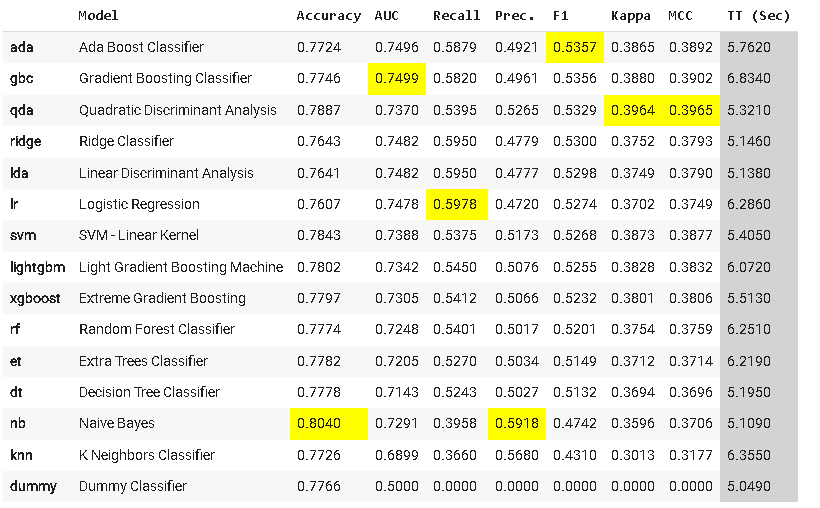

In [ ]:
# backward selection Pycaret
# Forward selection Pycaret
# variables
variables = ['LIMIT_BAL',
             'July_Pay_status',
             'June_Pay_status',
             'May_Pay_status',
             'Momentum',
             'repayment_volatility',
             'momentum_stability_flag',
             'super_default_score_final_log',
             'risk_index_1_log',
             'momentum_recent_mean_interaction_log',
             'recent_repayment_mean_log',
             'average_repayment_status_log',
             'momentum_volatility_interaction_log']

# Create a new dataframe with selected features and target
df_pycaret = df_filtered[variables + ['default_payment_next_month']]

# Set up PyCaret classification environment
clf_setup = setup(
    # data
    data=df_pycaret,

    # target
    target='default_payment_next_month',

    # reproducibility
    session_id=42,

    # normalization
    normalize=True,
    normalize_method= "robust",

    # imbalance
    fix_imbalance=True,
    fix_imbalance_method= "smotetomek",

    # experiment name
    experiment_name='baseline_backward',

    verbose=True)

# Compare all models
best_models = compare_models(sort='F1')

,Description,Value
0,Session id,42
1,Target,default_payment_next_month
2,Target type,Binary
3,Original data shape,"(29163, 14)"
4,Transformed data shape,"(40215, 14)"
5,Transformed train set shape,"(31466, 14)"
6,Transformed test set shape,"(8749, 14)"
7,Numeric features,11
8,Categorical features,2
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7902,0.7580,0.5467,0.5295,0.5379,0.4022,0.4024,4.2570
svm,SVM - Linear Kernel,0.7863,0.7455,0.5458,0.5215,0.5329,0.3946,0.3951,1.6270
lda,Linear Discriminant Analysis,0.7678,0.7593,0.5864,0.4837,0.5301,0.3777,0.3808,1.5660
ridge,Ridge Classifier,0.7677,0.7593,0.5860,0.4836,0.5298,0.3775,0.3805,1.4770
ada,Ada Boost Classifier,0.7717,0.7550,0.5757,0.4910,0.5296,0.3802,0.3825,2.3510
qda,Quadratic Discriminant Analysis,0.7947,0.7521,0.5169,0.5426,0.5294,0.3982,0.3984,1.5490
lr,Logistic Regression,0.7636,0.7588,0.5910,0.4765,0.5276,0.3724,0.3762,2.4930
lightgbm,Light Gradient Boosting Machine,0.7988,0.7426,0.4939,0.5563,0.5231,0.3962,0.3974,2.9240
xgboost,Extreme Gradient Boosting,0.7909,0.7279,0.4748,0.5369,0.5037,0.3719,0.3732,1.8020
nb,Naive Bayes,0.8004,0.7443,0.4057,0.5760,0.4758,0.3572,0.3657,1.5580


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Results of Fitting into Pycaret: Backward Selection
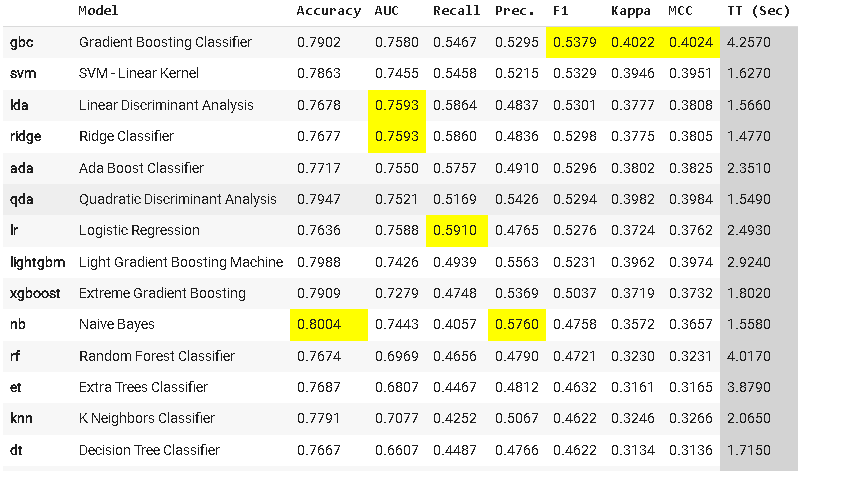

## Tuning & Optimiziation